<a href="https://colab.research.google.com/github/TrollRider-Kristian/Springboard-AI-Mini-Projects/blob/main/codebasics_bagging_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas
import seaborn
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Force Pandas to display ALL columns when I call the .head function
# https://stackoverflow.com/questions/11361985/output-data-from-all-columns-in-a-dataframe-in-pandas
pandas.set_option ('display.max_columns', None)
heart_disease_raw = pandas.read_csv ("heart-disease.csv")
print (heart_disease_raw.head(10))

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1     

Per the describe() call, all the quantifiable columns with means and standard deviations for which a Z-score exists are: Age, RestingBP, Cholesterol, FastingBS, MaxHR, and Oldpeak. We omit the target 'HeartDisease' column.

In [2]:
heart_disease_raw.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [3]:
heart_disease_raw.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [4]:
# Feature names with mean and standard deviation from the dataset
quantifiable_feature_list = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

# The Z-score, also called the Standard Score: https://en.wikipedia.org/wiki/Standard_score
# I was advised to remove outliers with a Z-score < -3 or > 3, as in any row with a value
# more than 3 standard deviations away from the mean.

def calculate_z_score (dataset, column_name):
  get_column = dataset [column_name]
  return (get_column - get_column.mean()) / get_column.std()

# Uncomment to test the addition of new columns for the z-score of each row of each feature.
# for feature_name in quantifiable_feature_list:
#   heart_disease_raw [feature_name + '-Z-score'] = calculate_z_score (heart_disease_raw, feature_name)
# print (heart_disease_raw.head(10))

In [5]:
def is_outlier_in_given_column (dataset, column_name):
  return abs (calculate_z_score (dataset, column_name)) > 3

def is_outlier (dataset, column_list):
  is_outlier = is_outlier_in_given_column (dataset, column_list[0])
  for column_name in column_list[1:]:
    is_outlier = is_outlier | is_outlier_in_given_column (dataset, column_name)
  return is_outlier

In [6]:
heart_disease_raw ['is_outlier'] = is_outlier (heart_disease_raw, quantifiable_feature_list)
print (heart_disease_raw ['is_outlier'].value_counts())

# A bit tricky to use the drop method on rows by condition, rather than specific indices, but it can be done.
# Docs on index method: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.index.html
# KRISTIAN_NOTE - I have a feeling I'll be using this method more in the future.
heart_disease_raw.drop (heart_disease_raw[heart_disease_raw ['is_outlier'] == True].index, inplace = True)
print (heart_disease_raw['is_outlier'].value_counts())
heart_disease_raw.drop (columns = 'is_outlier', inplace = True) # Drop the outliers column once we've removed outliers.

is_outlier
False    899
True      19
Name: count, dtype: int64
is_outlier
False    899
Name: count, dtype: int64


There are five columns that require one-hot encoding before I can train models with this dataset:
1. Sex ['F', 'M']
2. ChestPainType ['ASY', 'ATA', 'NAP', 'TA']
3. RestingECG ['LVH', 'Normal', 'ST']
4. ExerciseAngina ['N', 'Y']
5. ST_Slope ['Down', 'Flat', 'Up']

This should yield 14 total bits with 1's indicating the applicable categories for each row.  For example, the following row:
{Sex: 'F', ChestPainType: 'ATA', RestingECG: 'Normal', Exerciseangina: 'N', ST_Slope: 'Up'}

will yield the following encoding:
[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]

In [7]:
# One-Hot Encoding works with a number of bits equal to the total number of categories (eg. Male: [1, 0]; Female: [0, 1]),
# but it can also work with multiple categories at a time.
heart_disease_category_names = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# See documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# See Wikipedia article: https://en.wikipedia.org/wiki/One-hot
one_hot = OneHotEncoder (handle_unknown = 'warn')
one_hot.fit (heart_disease_raw[heart_disease_category_names])
print (one_hot.categories_)

[array(['F', 'M'], dtype=object), array(['ASY', 'ATA', 'NAP', 'TA'], dtype=object), array(['LVH', 'Normal', 'ST'], dtype=object), array(['N', 'Y'], dtype=object), array(['Down', 'Flat', 'Up'], dtype=object)]


In [8]:
encoded_categories = one_hot.transform (heart_disease_raw[heart_disease_category_names]).toarray().tolist()
# print (encoded_categories[0:3]) # Uncomment to check if categories correctly encoded.

one_hot_encoded_columns = pandas.DataFrame (encoded_categories, columns = one_hot.get_feature_names_out())
print (one_hot_encoded_columns.shape)

(899, 14)


In [9]:
# When the index numbers between the rows on a pair of DataFrames does not align perfectly,
# it creates extra rows populated with NaN values for several features.  Even if both
# DataFrames have the exact same number of rows, one can accidentally concat them
# together into a DataFrame with more rows than the pair used to create it.
# The easiest workaround is to simply remove the indices from each DataFrame before merging
# as this workaround suggests:
# https://stackoverflow.com/questions/45963799/pandas-concat-resulting-in-nan-rows
# KRISTIAN_NOTE - This workaround is acceptable for this project because we don't care about
# the indices for this particular dataset.
heart_disease_raw.reset_index (drop = True, inplace = True)
one_hot_encoded_columns.reset_index (drop = True, inplace = True)
encoded_heart_disease_df = pandas.concat (\
  [heart_disease_raw, one_hot_encoded_columns],\
  axis = 'columns'\
)
print (encoded_heart_disease_df.shape)

(899, 26)


In [10]:
encoded_heart_disease_df.drop (columns = heart_disease_category_names, inplace = True)
print (encoded_heart_disease_df.head(10))

   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   
5   39        120          339          0    170      0.0             0   
6   45        130          237          0    170      0.0             0   
7   54        110          208          0    142      0.0             0   
8   37        140          207          0    130      1.5             1   
9   48        120          284          0    120      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
0    0.0    1.0                0.0                1.0                0.0   
1    1.0    0.0       

In [11]:
print (encoded_heart_disease_df.isnull().sum())

Age                  0
RestingBP            0
Cholesterol          0
FastingBS            0
MaxHR                0
Oldpeak              0
HeartDisease         0
Sex_F                0
Sex_M                0
ChestPainType_ASY    0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_LVH       0
RestingECG_Normal    0
RestingECG_ST        0
ExerciseAngina_N     0
ExerciseAngina_Y     0
ST_Slope_Down        0
ST_Slope_Flat        0
ST_Slope_Up          0
dtype: int64


In [12]:
# At last, we split the dataset by dropping the 'HeartDisease' column and saving it as the target vector.
heart_disease_features = encoded_heart_disease_df.drop (columns = 'HeartDisease')
heart_disease_target = encoded_heart_disease_df['HeartDisease']
print (heart_disease_features.head())
print (heart_disease_target.head())

   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Sex_F  Sex_M  \
0   40        140          289          0    172      0.0    0.0    1.0   
1   49        160          180          0    156      1.0    1.0    0.0   
2   37        130          283          0     98      0.0    0.0    1.0   
3   48        138          214          0    108      1.5    1.0    0.0   
4   54        150          195          0    122      0.0    0.0    1.0   

   ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0                0.0                1.0                0.0               0.0   
1                0.0                0.0                1.0               0.0   
2                0.0                1.0                0.0               0.0   
3                1.0                0.0                0.0               0.0   
4                0.0                0.0                1.0               0.0   

   RestingECG_LVH  RestingECG_Normal  RestingECG_ST  ExerciseAngina_

In [13]:
# KRISTIAN_NOTE - Looks pretty evenly split between people with heart disease and people without.
print (heart_disease_target.value_counts())

HeartDisease
1    492
0    407
Name: count, dtype: int64


In [14]:
# Same as logistic regression project, scale each column by the standard deviation of its features
scaler = StandardScaler (with_std = True)

# But in this case, codebasics scales ALL the features, as opposed to scaling both the training and test sets by the
# standard deviation of only the training set after a train/test split.  Let's only scale the columns that aren't one-hot encoded.
scaled_features = scaler.fit_transform (heart_disease_features[quantifiable_feature_list])

In [15]:
# Because the outcomes are almost evenly split between 0 and 1 for heart disease,
# I don't think 'stratify = heart_disease_target' will be necessary.
features_train, features_test, targets_train, targets_test = train_test_split(\
  scaled_features, heart_disease_target, random_state = 8\
)

In [16]:
svc_model = SVC (random_state = 8)
svc_model.fit (features_train, targets_train)
print (svc_model.score (features_test, targets_test))

0.7244444444444444


In [17]:
bagging_svc_model = BaggingClassifier (\
  estimator = SVC(),\
  n_estimators = 40,\
  max_features = 0.8,\
  bootstrap = True,\
  oob_score = True,\
  random_state = 8\
)
bagging_svc_model.fit (features_train, targets_train)
print (bagging_svc_model.score (features_test, targets_test))
print (bagging_svc_model.oob_score_)

0.7511111111111111
0.7759643916913946


In [18]:
decision_tree_model = DecisionTreeClassifier (criterion = 'gini', random_state = 8)
decision_tree_model.fit (features_train, targets_train)
print (decision_tree_model.score (features_test, targets_test))

0.6755555555555556


In [19]:
bagging_tree_model = BaggingClassifier (\
  estimator = DecisionTreeClassifier(),\
  n_estimators = 40,\
  max_features = 0.8,\
  bootstrap = True,\
  oob_score = True,\
  random_state = 8\
)
bagging_tree_model.fit (features_train, targets_train)
print (bagging_tree_model.score (features_test, targets_test))
print (bagging_tree_model.oob_score_)

0.7155555555555555
0.7418397626112759


<Axes: >

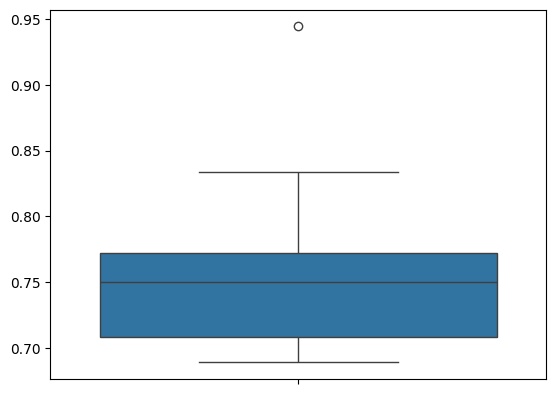

In [23]:
random_svc_model = SVC()

random_bagging_svc_model = BaggingClassifier(\
  estimator = SVC(),\
  n_estimators = 100,\
  max_features = 0.8,\
  bootstrap = True,\
)

random_decision_tree_model = DecisionTreeClassifier (criterion = 'gini')

random_bagging_tree_model = BaggingClassifier (\
  estimator = DecisionTreeClassifier(),\
  n_estimators = 100,\
  max_features = 0.8,\
  bootstrap = True,\
)

# How to show four different models in the same boxplot?
svc_scores = cross_val_score (random_svc_model, scaled_features, heart_disease_target, cv = 10)
seaborn.boxplot (data = svc_scores)